In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from bayes_opt import BayesianOptimization

from lightgbm import LGBMClassifier
import lightgbm as lgb

# Config
is_GPU_accelerated = False
is_pretuned = True 
isPretty = True

In [2]:
pwd()

'C:\\Users\\bob\\Jupyter\\MML\\03 Cybersec'

In [3]:
# Next, we'll bring in the training data and merge with additional information

print('Importing training data...')

X = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
X_id = pd.read_csv('ieee-fraud-detection/train_identity.csv')
X = pd.merge(X, X_id, on='TransactionID', how='left')
del X_id

target = 'isFraud'
indexCol = 'TransactionID'
remove_features = [target]
features = [col for col in list(X) if col not in remove_features]
labelEncoders = {}

y = X[target]

print('Done.')

Importing training data...
Done.


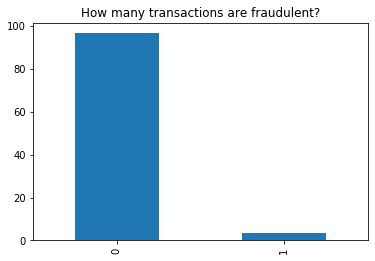

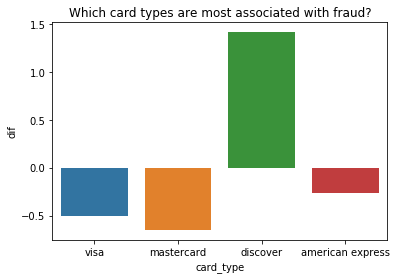

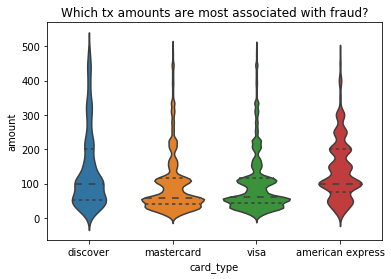

In [4]:
if isPretty:
    fradulentTx = X[X['isFraud'] == 1]
    validTx = X[X['isFraud'] == 0]

    # How many transactions are fraudulent?
    fig, ax = plt.subplots()
    ax = X['isFraud'].value_counts(normalize=True).map(lambda x: x * 100).plot.bar() # % isFraud in training data
    ax.title.set_text('How many transactions are fraudulent?')

    # Which card types are most associated with fraud?
    cardTypeFraud = fradulentTx['card4'].value_counts(normalize=True).map(lambda x: x * 100).to_frame().reset_index()
    cardTypeFraud.columns = ['card_type', 'fraud_freq']
    cardTypeValid = validTx['card4'].value_counts(normalize=True).map(lambda x: x * 100).to_frame().reset_index()
    cardTypeValid.columns = ['card_type', 'valid_freq']
    cardType = pd.merge(cardTypeFraud, cardTypeValid, on='card_type')
    cardType['dif'] = cardType['fraud_freq'] - cardType['valid_freq']
    fig, ax = plt.subplots()
    sns.barplot(x="card_type", y="dif", data=cardType, ax=ax)
    ax.title.set_text('Which card types are most associated with fraud?')

    # Which tx amounts under $500 are most associated with fraud?
    txUnder500 = X[X['TransactionAmt'] < 500][['TransactionAmt', 'card4']]
    txUnder500.columns = ['amount', 'card_type']
    fig, ax = plt.subplots()
    sns.violinplot(x="card_type", y="amount", split=True, inner="quart", data=txUnder500, ax=ax)
    ax.title.set_text('Which tx amounts are most associated with fraud?')

In [5]:
# We'll setup some preprocessing helpers.

def convertLabels(df):
    for col in df.columns:
        if df[col].dtypes == np.object:
            uniques = df[col].unique()
            labelEncoders[col] = preprocessing.LabelEncoder()
            labelEncoders[col].fit(uniques)
            labelEncoderDict = dict(zip(labelEncoders[col].classes_, labelEncoders[col].transform(labelEncoders[col].classes_)))
            df[col] = df[col].apply(lambda x: labelEncoderDict.get(x, '<UNK>'))

def convertToType(dfCol, npType): # Convert to numpy type
    dfCol = dfCol.astype(npType)

def convertToFloat32(df): # Convert numeric data to float32 or int32
    for col in df.columns:
        if df[col].dtypes != np.object and df[col].dtypes != np.int32:
            convertToType(df[col], np.float32)
            
def fillCatNan(df, filler): # Fill missing string values
    for col in df.columns:
        if df[col].dtypes == np.object:
            df[col].fillna(filler, inplace=True)
            
def fillValNan(df, filler): # Fill missing numeric values
    for col in df.columns:
        if df[col].dtypes != np.object:
            df[col].fillna(0.0, inplace=True)
            
def scaleVals(df, target): # Scale values
    for col in df.columns:
        if col != target and col != indexCol and df[col].dtypes != np.object:
            scaler = RobustScaler().fit(df[col].values.reshape(-1, 1))
            df[col] = scaler.transform(df[col].values.reshape(-1, 1))

            
# For the sake of simplicity, I'll convert numbers to float32.
# Empty string values will be replaced with '<UNK>'.
# Empty numeric values will be replaced with 0.0.

def preprocess(df):
    convertToType(df[indexCol], np.int32)
    fillCatNan(df ,'<UNK>')
    fillValNan(df , 0.0)
    convertLabels(df)
    scaleVals(df, target)
    
    
print('Converting to float32...')

X = X[features] # Only keep feature columns
preprocess(X) # Fill missing values / Reduce memory footprint

print('Done.')

Converting to float32...
Done.


In [6]:
def bays_kfold_optimizer(X, y,
                         model_constructor, fold_constructor,
                         fold_params, bounds, defaults, parms_int, params_fit,
                         splits=5, init_points=10, iterations=15, random_state=1):
    def compute_roc_auc(model,index):
        y_predict = model.predict_proba(X.iloc[index])[:,1]
        fpr, tpr, thresh = roc_curve(y.iloc[index], y_predict)
        auc_score = auc(fpr, tpr)
        return fpr, tpr, auc_score
    
    def build_model(**params):
        for param in parms_int:
            params[param] = int(params[param])
        
        model = model_constructor(**params, **defaults)

        all_auc_val_score = []
        for i in range(folds.n_splits):
                model.fit(X.iloc[X_ids[i],:], y.iloc[X_ids[i]], **params_fit)
                fpr, tpr, auc_score = compute_roc_auc(model, y_ids[i])
                all_auc_val_score.append(auc_score)

        return np.mean(all_auc_val_score)

    folds = fold_constructor(n_splits=splits, **fold_params)
    X_ids = []
    y_ids = []

    for (train, test), i in zip(folds.split(X, y), range(splits)):
        X_ids.append(train)
        y_ids.append(test)
        
    model_optimizer = BayesianOptimization(build_model, bounds, random_state=random_state)
    print(model_optimizer.space.keys)

    model_optimizer.maximize(init_points=init_points, n_iter=iterations, acq='ucb', xi=0.0, alpha=1e-6)

    print(model_optimizer.max['target'])
    params = model_optimizer.max['params']
    
    for param in parms_int:
        params[param] = int(params[param])
        
    print(params)
    
    return params

In [7]:
# Optimize LightGBM model parameters

best_params_lgb = {
    'num_leaves': 568,
    'min_data_in_leaf': 50,
    'n_estimators': 1795,
    'min_child_weight': 0.027327584490198106,
    'bagging_fraction': 0.4583494036456541,
    'feature_fraction': 0.4492446997014985,
    'learning_rate': 0.009019314773844423,
    'reg_alpha': 0.23150921255961304,
    'reg_lambda': 0.6834953421726443
}

if not is_pretuned:
    params_fold = {
        'shuffle': True
    }

    bounds_LGB = {
        'num_leaves': (200, 800), 
        'min_data_in_leaf': (50, 250),
        'n_estimators': (750, 1800),
        'min_child_weight': (0.01, 0.05),
        'bagging_fraction' : (0.2, 0.6),
        'feature_fraction' : (0.15, 0.6),
        'learning_rate': (0.005, 0.01),
        'reg_alpha': (0.2, 0.6), 
        'reg_lambda': (0.25, 1.0),
    }

    params_default_LGB = {
        'objective': 'binary',
        'max_depth': -1,
        'boosting_type': 'gbdt',
        'bagging_seed': 11,
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 47
    }
    
    if is_GPU_accelerated:
        params_default_LGB['device'] = 'gpu',
        params_default_LGB['gpu_platform_id'] = 0,
        params_default_LGB['gpu_device_id'] = 0,

    params_int = ['num_leaves', 'min_data_in_leaf', 'n_estimators']
    
    params_fit = {
        'eval_metric': 'AUC'
    }

    params_fold = {
        'shuffle': True
    }

    best_params_lgb = bays_kfold_optimizer(X, y,
                                           LGBMClassifier, StratifiedKFold,
                                           params_fold, bounds_LGB, params_default_LGB, params_int,
                                           params_fit, splits=5, init_points=10, iterations=15,
                                           random_state=1)

In [8]:
# Train and save the best model, and it's parameters for later use

trained_best_lgb = LGBMClassifier(**best_params_lgb).fit(X, y)
pickle.dump(best_params_lgb, open( "best_params_lgb.pickle", "wb" ))
pickle.dump(trained_best_lgb, open( "trained_best_lgb.pickle", "wb" ))

In [9]:
# Now, we'll load the test data

print('Importing test data...')

X_pred = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
X_id_pred = pd.read_csv('ieee-fraud-detection/test_identity.csv')
X_pred = pd.merge(X_pred, X_id_pred, on='TransactionID', how='left')[features]
del X_id_pred

preprocess(X_pred)

print('Done.')

Importing test data...
Done.


In [13]:
# Calculate our predictions...
print('Calculating predictions...')

y_pred = []
i, chunksize = 0, 10000
model = pickle.load( open( "trained_best_lgb.pickle", "rb" ) )
for idx in range(0, len(X_pred), chunksize):
    batch = X_pred[idx:(i+1)*chunksize]
    pred = model.predict_proba(batch) # Predict with probability score
    y_pred += list(pred)
    i += 1

y_pred = np.array(y_pred)
y_pred = np.delete(y_pred, 0, axis=1).flatten() # Only keep probability of isFraud

print('Done.')

Calculating predictions...
Done.


In [14]:
y_pred

array([[9.99485071e-01, 5.14929284e-04],
       [9.99375035e-01, 6.24964908e-04],
       [9.98714163e-01, 1.28583728e-03],
       ...,
       [9.94235379e-01, 5.76462101e-03],
       [9.94548909e-01, 5.45109062e-03],
       [9.95456575e-01, 4.54342519e-03]])